# Пространства имен [Namespaces]

Пространство имён - отображение из имен переменных в объекты.

В коде может быть несколько пространств имён.

### Циклы и условия не создают своё пространство имён

In [7]:
for i in range(3):
    a = i ** 2

print(a)

4


In [8]:
if True:
    a = 2
    
print(a)

2


### locals() - возвращает текущий namespace в виде словаря
### globals() - возвращает namespace модуля

In [13]:
locals() == globals()

True

In [18]:
def test():
    x = 1
    print(locals(), 'x' in globals(), 'x' in locals())

test()

{'x': 1} False True


### Функции создают свой namespace

In [19]:
def f():
    in_func = 2

f()
in_func

NameError: name 'in_func' is not defined

### Область видимости (scope)

Правило LEGB:

1) Local - имена, определенные внутри функции (и не помеченные global)

2) Enclosing-function locals - имена в области видимости всех оборачивающих (enclosing) функций, в порядке уменьшения глубины

3) Global - глобальные имена, определенные на уровне модуля или посредством global

4) Built-in - предопределенные (range, open, ...)

In [29]:
def outer():
    range = 'outer range'
    x = 'x'
    
    def inner():
        range = 'inner range'
        print('inner:', range, x)
        
    inner()
    print('outer:', range)
    
outer()
print(range)
print(x)

inner: inner range x
outer: outer range
<class 'range'>


NameError: name 'x' is not defined

In [26]:
global_var = 'global_var'

def test():
    global_var = 'global_var_modified'
    print(global_var)  # global_var shadows another variable with same name


test()
print(global_var)

global_var_modified
global_var


### ключевое слово global

In [27]:
global_var = 'global_var'

def test():
    global global_var
    global_var = 'global_var_modified'
    print(global_var)  # global_var is in enclosing namespaces


test()
print(global_var)


global_var_modified
global_var_modified


### Замечание
__Функции имеют доступ к внешним пространствам имён относительно того места, где они были _определены_, а не _вызваны_ __

In [114]:
def f():
    print(it)

def q(func):
    for it in range(10):
        func()

q(f)

NameError: name 'it' is not defined

### Проблема

In [1]:
def outer():
    first_var = 'v1'
    second_var = 'v2'

    def inner():
        global first_var
        first_var = 'v1_updated'
        print('inner:', first_var)
        print('inner:', second_var)

    inner()
    
    print('outer:', first_var)
    print('outer:', second_var)

    
outer()
print('global:', first_var)
print('global:', second_var)

inner: v1_updated
inner: v2
outer: v1
outer: v2
global: v1_updated


NameError: name 'second_var' is not defined

### Решение

In [2]:
def outer():
    nonlocal_first_var = 'v1'
    nonlocal_second_var = 'v2'

    def inner():
        nonlocal nonlocal_first_var
        nonlocal_first_var = 'v1_updated'
        print('inner:', nonlocal_first_var)
        print('inner:', nonlocal_second_var)

    inner()
    
    print('outer:', nonlocal_first_var)
    print('outer:', nonlocal_second_var)

    
outer()
print('global:', nonlocal_first_var)
print('global:', nonlocal_second_var)

inner: v1_updated
inner: v2
outer: v1_updated
outer: v2


NameError: name 'nonlocal_first_var' is not defined

### Чуть более странное решение

In [3]:
def outer():
    
    outer.var = 'v1'

    def inner():
        outer.var = 'v2'
        print('inner:', outer.var)

    inner()
    
    print('outer:', outer.var)

outer()

inner: v2
outer: v2


# Замыкания [Closures]
*In computer programming languages, a closure is a function together with a referencing environment of that function. A closure function is any function that uses a variable that is defined in an environment (or scope) that is external to that function, and is accessible within the function when invoked from a scope in which that free variable is not defined.*

Существования замыканий следует из правила LEGB, возможности оперировать с функциями как обьектами и того что области видимости в Питоне - статические.

In [4]:
def make_adder(x):
    def adder(y):
        return x + y
    return adder

In [5]:
add_two = make_adder(2)

add_two(7)

9

In [6]:
def cell(value = 0):
    def get():
        return value
    
    def set(new_value):
        nonlocal value
        value = new_value
        return value
    
    return get, set

get, set = cell(10)
print(get())

set(20)

print(get())

10
20


In [7]:
def make_adder(x):
    def add(y):
        return x + y
    
    def update(new_x):
        nonlocal x
        x = new_x

    add.update = update
    return add

adder = make_adder(10)
print(adder(10))

adder.update(100)

print(adder(10))

20
110


### Посмотрим внутрь

In [8]:
print(adder.__closure__)
print(repr(adder.__closure__[0].cell_contents))

(<cell at 0x10e16ceb8: int object at 0x10be76730>,)
100


In [9]:
adder.update.__closure__ == adder.__closure__ 

True

# Декораторы

Замыкания как способ быстро изменить поведение функции

In [10]:
import sys

def deprecate(func):
    def inner(*args, **kwargs):
        print('{} is deprecated'.format(func.__name__), file=sys.stderr)
        return func(*args, **kwargs)
    return inner

pprint = deprecate(print)

pprint([1, 2, 3])

[1, 2, 3]


print is deprecated


### Наблюдение

In [11]:
import sys

def deprecated(func):
    def wrapper(*args, **kwargs):
        print('{} is deprecated'.format(func.__name__), file=sys.stderr)
        return func(*args, **kwargs)
    return wrapper

@deprecated
def show(x):
    print(x)

show([1, 2, 3])

[1, 2, 3]


show is deprecated


### Проблема

In [13]:
@deprecated
def show(x):
    'This is a really nice looking docstring'
    print(x)

print(show.__name__)
print(show.__doc__)

wrapper
None


### Решение 1

In [14]:
def deprecated(func):
    def wrapper(*args, **kwargs):
        print('{} is deprecated!'.format(func.__name__), file=sys.stderr)
        return func(*args, **kwargs)
    wrapper.__name__ = func.__name__
    wrapper.__doc__ = func.__doc__
    wrapper.__module__ = func.__module__
    return wrapper

@deprecated
def show(x):
    'This is a really nice looking docstring'
    print(x)

print(show.__name__)
print(show.__doc__)

show
This is a really nice looking docstring


### Решение 2

In [17]:
import functools

def deprecated(func):
    @functools.wraps(func) 
    def wrapper(*args, **kwargs):
        print('{} is deprecated!'.format(func.__name__), file=sys.stderr)
        return func(*args, **kwargs)
    return wrapper

@deprecated
def show(x):
    'This is a really nice looking docstring'
    print(x)

print(show.__name__)
print(show.__doc__)

show
This is a really nice looking docstring


In [18]:
def trace(dest=sys.stderr):
    def wraps(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            print('{} called with args {}, kwargs {}!'.format(func.__name__, args, kwargs), file = dest)
            return func(*args, **kwargs)
        return wrapper
    return wraps

@trace(sys.stdout) 
def f(x, test):
    if test > 1:
        return f(x, test / 2)

f('Hi!', test=42)

f called with args ('Hi!',), kwargs {'test': 42}!
f called with args ('Hi!', 21.0), kwargs {}!
f called with args ('Hi!', 10.5), kwargs {}!
f called with args ('Hi!', 5.25), kwargs {}!
f called with args ('Hi!', 2.625), kwargs {}!
f called with args ('Hi!', 1.3125), kwargs {}!
f called with args ('Hi!', 0.65625), kwargs {}!


### Практика :: Декоратор Once

In [19]:
def once(func):
    def wrapper(*args, **kwargs):
        nonlocal called
        if not called:
            called = True
            return func(*args, **kwargs)

    called = False
    return wrapper

@once
def f():
    print('Hi!')

f()
f()

Hi!


### Декораторам необязательно быть функциями

In [23]:
from collections import Counter 

class Register(object):
    def __init__(self):
        self.stat = Counter()
        
    def __call__(self, func):
        nm = func.__name__
        def wrapper(*args, **kwrags):
            self.stat[nm] += 1
            return func(*args, **kwrags)
        return wrapper
    
    def __str__(self):
        result = 'fname\tcallcount\n'
        for name, count in self.stat.items():
            result += '{}:\t{}\n'.format(name, count)
        return result
    
register = Register()

In [24]:

@register
def f(x):
    return x 

@register
def q(x):
    return q

f(1), q(2), q(4)
q(2), f(5)
print(register)

fname	callcount
f:	2
q:	3



### List comprehensions

In [25]:
[x**2 for x in range(10)]

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [28]:
noprimes = [j for i in range(2, 8) for j in range(i * 2, 50, i)]
print(noprimes)

[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 10, 15, 20, 25, 30, 35, 40, 45, 12, 18, 24, 30, 36, 42, 48, 14, 21, 28, 35, 42, 49]


In [29]:
[x for x in range(2, 50) if x not in noprimes]

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]

In [32]:
words = 'The quick brown fox jumps over the lazy dog'.split()
print(words)

['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


In [33]:
[[w.upper(), w.lower(), len(w)] for w in words]

[['THE', 'the', 3],
 ['QUICK', 'quick', 5],
 ['BROWN', 'brown', 5],
 ['FOX', 'fox', 3],
 ['JUMPS', 'jumps', 5],
 ['OVER', 'over', 4],
 ['THE', 'the', 3],
 ['LAZY', 'lazy', 4],
 ['DOG', 'dog', 3]]

In [7]:
[(x,y,z) for x in range(1,30) for y in range(x,30) for z in range(y,30) if x**2 + y**2 == z**2]

[(3, 4, 5),
 (5, 12, 13),
 (6, 8, 10),
 (7, 24, 25),
 (8, 15, 17),
 (9, 12, 15),
 (10, 24, 26),
 (12, 16, 20),
 (15, 20, 25),
 (20, 21, 29)]

In [8]:
colours = ["red", "green", "yellow", "blue"]
things = ["house", "car", "tree"]
[(x,y) for x in colours for y in things]

[('red', 'house'),
 ('red', 'car'),
 ('red', 'tree'),
 ('green', 'house'),
 ('green', 'car'),
 ('green', 'tree'),
 ('yellow', 'house'),
 ('yellow', 'car'),
 ('yellow', 'tree'),
 ('blue', 'house'),
 ('blue', 'car'),
 ('blue', 'tree')]

### Некоторые положения PEP-8

#### отступ в 4 пробела
#### пробелы предпочительнее табов
#### максимальная длина строки-79 символов
#### функции и классы отделяются 2 \n
#### методы отделяются 1 \n
#### \n должны использоваться для отделения логических частей кода друг от друга

In [ ]:
Yes: import os
     import sys

No:  import sys, os

In [ ]:
No: from module import *

In [ ]:
Yes: spam(ham[1], {eggs: 2})
No:  spam( ham[ 1 ], { eggs: 2 } )

In [ ]:
Yes: foo = (0,)
No:  bar = (0, )

In [ ]:
Yes: if x == 4: print x, y; x, y = y, x
No:  if x == 4 : print x , y ; x , y = y , x

In [ ]:
Yes: spam(1)
No:  spam (1)

In [ ]:
Yes: dct['key'] = lst[index]
No:  dct ['key'] = lst [index]

In [ ]:
#если есть операторы с разными приоритетами, то рекомендуется окружать пробелами оператор с меньшим приоритетом
Yes:
i = i + 1
submitted += 1
x = x*2 - 1
hypot2 = x*x + y*y
c = (a+b) * (a-b)

No:
i=i+1
submitted +=1
x = x * 2 - 1
hypot2 = x * x + y * y
c = (a + b) * (a - b)

In [ ]:
Yes:
def complex(real, imag=0.0):
    return magic(r=real, i=imag)

No:
def complex(real, imag = 0.0):
    return magic(r = real, i = imag)

### pylint - анализатор кода

### Useful magic

In [1]:
from matplotlib import pyplot
import random

In [2]:
pyplot.hist([random.randrange(0, 10) for _ in range(100)])

(array([ 11.,   9.,   9.,   7.,   6.,  13.,  10.,  14.,  12.,   9.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

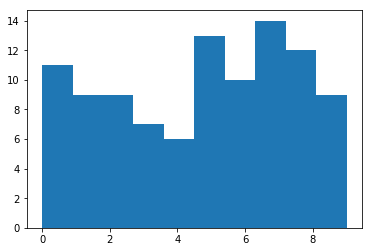

In [3]:
pyplot.show()

In [4]:
%matplotlib inline

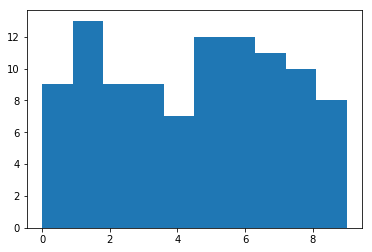

In [5]:
_ = pyplot.hist([random.randrange(0, 10) for _ in range(100)])

In [34]:
%pwd
#%cd

'/Users/kuzmichevd/Downloads'

In [6]:
%magic